# CogPonder: Stroop task with fixed hyper-parameters

This notebook implements the CogPonder framework using PyTorch Lightning and evaluate it on the Stroop task.


It assumes fixed hyper-parameters and fits the model to a single-subject dataset. It wraps a simple linear network with a pondering layer and trains it on a random subject from the *Self-Regulation Ontology* dataset.


## Data

Here, we fit the Stroop data from the *Self-Regulation Ontology*. The data is loaded from the `data/Self_Regulation_ontology/` directory; see the corresponding [README](../data/Self_Regulation_Ontology/README.md) for more information on the data structure.

### Input and Output


The input is a list of trials, including 1) the color and 2) the letter of the current stimulus. The output is the human response to the current trial (i.e., red, green, or blue), and response time.


## Hyper-parameters

- `n_embeddings`: number of hidden units in the operator model. Defaults to 8.
- `resp_loss_beta`: the beta parameter of the loss function. Defaults to 1.
- `time_loss_beta`: the beta parameter of the loss function. Defaults to 10.
- `learning_rate`: the learning rate of the optimizer. Defaults to 0.001.
- `max_response_step`: maximum response step. Defaults to the maximum response time in the dataset divided by the response_step_interval.
- `response_step_interval`: the interval between response steps. Defaults to 10ms.

## Criterion

The loss function is a weighted sum of the reconstruction loss ($L_{\text{response}}$) which measures the corss-entropy loss between human response and predicted response, and is regularized by the response time loss ($L_{\text{time}}$), which measures the KL-div between human response times and predicted response times.

$L_{\text{total}} = \sum pL_{\text{response}} + \beta L_{\text{time}}$


In [5]:
%reload_ext autoreload
%autoreload 3

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

import torch
import pytorch_lightning as pl
import pandas as pd
from pytorch_lightning.callbacks import EarlyStopping
from src.cogponder import CogPonderModel
from src.cogponder.data import StroopSRODataset, CogPonderDataModule
from pathlib import Path

In [6]:
# number of maximum epochs to train (early stopping will be applied)
# early stopping patience is 10% of max_epochs (min 10 epochs)
MAX_EPOCHS = 10
BATCH_SIZE = 1024

# upon successful training, the trained model will be saved to this path
CHECKPOINT_PATH = Path('models') / 'stroop' / f'cogponder_epochs-{MAX_EPOCHS}.ckpt'

In [9]:
# Load the dataset and configs

print(f'Loading Stroop dataset... ', end='')

dataset = StroopSRODataset(response_step_interval=20, non_decision_time='auto')
datamodule = CogPonderDataModule(dataset, batch_size=BATCH_SIZE, num_workers=8)

# determine some parameters from data
n_contexts = torch.unique(dataset[:][2]).size(0)
n_subjects = torch.unique(dataset[:][1]).size(0)
n_symbols = torch.unique(dataset[:][1]).size(0)
n_outputs = torch.unique(dataset[:][4]).size(0)
max_response_step = dataset[:][5].max().int().item() + 10


configs = {
    'inputs_dim': dataset[:][3].size(1),
    'outputs_dim': n_outputs,
    'embeddings_dim': 8,
    'response_loss_beta': 1.,
    'time_loss_beta': 10.,
    'learning_rate': 1e-2,
    'max_response_step': max_response_step,
    'subject_embeddings_dim': 2,
    'n_subjects': n_subjects,
    'n_contexts': n_contexts,
    'task': 'stroop'
}

print('Done!')

Loading Stroop dataset... Done!


Now, we train the model.

In [10]:
# Define the pondering model and run the trainer

model = CogPonderModel(**configs)

# TODO: check if torch>=2.0 is installed
# model = torch.compile(model)

# Trainer
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    # min_epochs=100,
    accelerator='auto',
    log_every_n_steps=1,
    # overfit_batches=True,
    # accumulate_grad_batches=2,
    callbacks=[
        EarlyStopping(monitor='val/total_loss',
                      patience=np.max([10, MAX_EPOCHS // 10]).item(),
                      mode='min', min_delta=0.001),
    ])

# Fit and evaluate the model
trainer.fit(model, datamodule=datamodule)

# Save the latest checkpoint
trainer.save_checkpoint(CHECKPOINT_PATH)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name               | Type                 | Params
------------------------------------------------------------
0 | operator_node      | SimpleOperatorModule | 108   
1 | halt_node          | HaltingModule        | 81    
2 | recurrence_node    | RecurrenceModule     | 336   
3 | subject_embeddings | Embedding            | 1.0 K 
4 | embeddings         | Embedding            | 16    
5 | resp_loss_fn       | ResponseLoss         | 0     
6 | time_loss_fn       | ResponseTimeLoss     | 0     
------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/morteza/micromamba/envs/cogponder/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Let's see how the model performs on the test set.

In [15]:
# DEBUG

# DEBUG - Load the checkpoint

model_ckpt = CogPonderModel.load_from_checkpoint(CHECKPOINT_PATH)
model_ckpt.eval()

# reload the data module if it is not loaded yet
if not 'datamodule' in locals() or not hasattr(datamodule, 'train_dataset'):
    print('loading data module...', end='')
    data = StroopSRODataset(n_subjects=-1, response_step_interval=10)[:]
    datamodule = CogPonderDataModule(data, batch_size=CONFIG['batch_size'], num_workers=8)
    datamodule.prepare_data()
    print('Done!')

C_train, X_train, trial_types_train, y_train, rt_train, corrects_trains = datamodule.train_dataset[:]
C_test, X_test, trial_types_test, y_test, rt_test, corrects_test = datamodule.test_dataset[:]

with torch.no_grad():
    model_ckpt.eval()

    y_train_steps,p_train,rt_train_pred = model_ckpt(C_train, X_train)
    y_test_steps,p_test,rt_test_pred = model_ckpt(C_test, X_test)

    y_train_steps = torch.argmax(y_train_steps, dim=-1)
    y_test_steps = torch.argmax(y_test_steps, dim=-1)

    y_train_pred = y_train_steps.gather(dim=0, index=rt_train_pred[None, :] - 1,)[0]  # (batch_size,)
    y_test_pred = y_test_steps.gather(dim=0, index=rt_test_pred[None, :] - 1,)[0]  # (batch_size,)

    train_res = pd.DataFrame({'true_rt_train': rt_train.detach().tolist(),
                              'pred_rt_train': rt_train_pred.tolist()})
    test_res = pd.DataFrame({'true_rt_test': rt_test.detach().tolist(),
                             'pred_rt_test': rt_test_pred.tolist()})

    display(train_res.T, test_res.T)

    # report Stroop accuracy
    is_corrects_pred = (y_test_pred.long() == y_test).float()
    cong_is_corrects = torch.where(trial_types_test == 1, is_corrects_pred, torch.nan)
    incong_is_corrects = torch.where(trial_types_test == 0, is_corrects_pred, torch.nan)

    accuracy = torch.nanmean(is_corrects_pred)
    cong_accuracy = torch.nanmean(cong_is_corrects)
    incong_accuracy = torch.nanmean(incong_is_corrects)

    print('Stroop %correct (total / congruent / incongruent): {:.3f} / {:.3f} / {:.3f}'.format(
            accuracy.item(), cong_accuracy.item(), incong_accuracy.item()))

# DEBUG report mean-RT
print(f'RT train mean (pred/true): '
      f'{rt_train_pred.float().mean().item():.2f}, '
      f'{rt_train.float().mean().item():.2f}')

print(f'RT test  mean (pred/true): '
      f'{rt_test_pred.float().mean().item():.2f}, '
      f'{rt_test.float().mean().item():.2f}')

# DEBUG - report sd-RT
print(f'RT train std (pred/true): '
      f'{rt_train_pred.float().std().item():.2f}, '
      f'{rt_train.float().std().item():.2f}')

print(f'RT test  std (pred/true): '
      f'{rt_test_pred.float().std().item():.2f}, '
      f'{rt_test.float().std().item():.2f}')



,0,1,2,3,4,5,6,7,8,9,...,36993,36994,36995,36996,36997,36998,36999,37000,37001,37002
true_rt_train,16,16,12,11,14,10,25,23,31,17,...,4,8,2,8,12,8,2,2,30,23
pred_rt_train,16,4,14,28,13,19,28,8,10,17,...,19,8,9,8,32,18,16,20,9,29


,0,1,2,3,4,5,6,7,8,9,...,12325,12326,12327,12328,12329,12330,12331,12332,12333,12334
true_rt_test,12,1,17,18,23,31,13,9,10,9,...,13,18,3,20,14,6,7,4,2,9
pred_rt_test,4,26,3,17,3,16,6,6,5,25,...,5,38,9,9,11,7,2,10,7,8


Stroop %correct (total / congruent / incongruent): 0.966 / 0.982 / 0.950
RT train mean (pred/true): 17.73, 16.30
RT test  mean (pred/true): 17.38, 16.40
RT train std (pred/true): 13.14, 10.00
RT test  std (pred/true): 13.18, 9.99


Plot the predicted response time distributions per condition.

In [16]:
# prepare plotting data

plot_data_train = pd.DataFrame({
    'rt': rt_train,
    'trial_type': trial_types_train,
    'color': X_train[:, 0],
    'word': X_train[:, 1],
    'data': 'truth',
    'split': 'train',
})

plot_data_train_pred = pd.DataFrame({
    'rt': rt_train_pred,
    'trial_type': trial_types_train,
    'color': X_train[:, 0],
    'word': X_train[:, 1],
    'data': 'pred',
    'split': 'train',
})

plot_data_test = pd.DataFrame({
    'rt': rt_test,
    'trial_type': trial_types_test,
    'color': X_test[:, 0],
    'word': X_test[:, 1],
    'data': 'truth',
    'split': 'test',
})

plot_data_test_pred = pd.DataFrame({
    'rt': rt_test_pred,
    'trial_type': trial_types_test,
    'color': X_test[:, 0],
    'word': X_test[:, 1],
    'data': 'pred',
    'split': 'test',
})

# merge and cleanup
plot_data = pd.concat([plot_data_train, plot_data_train_pred, plot_data_test, plot_data_test_pred])
plot_data['trial_type'] = plot_data['trial_type'].map({0: 'incongruent', 1: 'congruent'})

max_rt = CONFIG["max_response_step"]

plot_data = plot_data.query('rt < @max_rt')

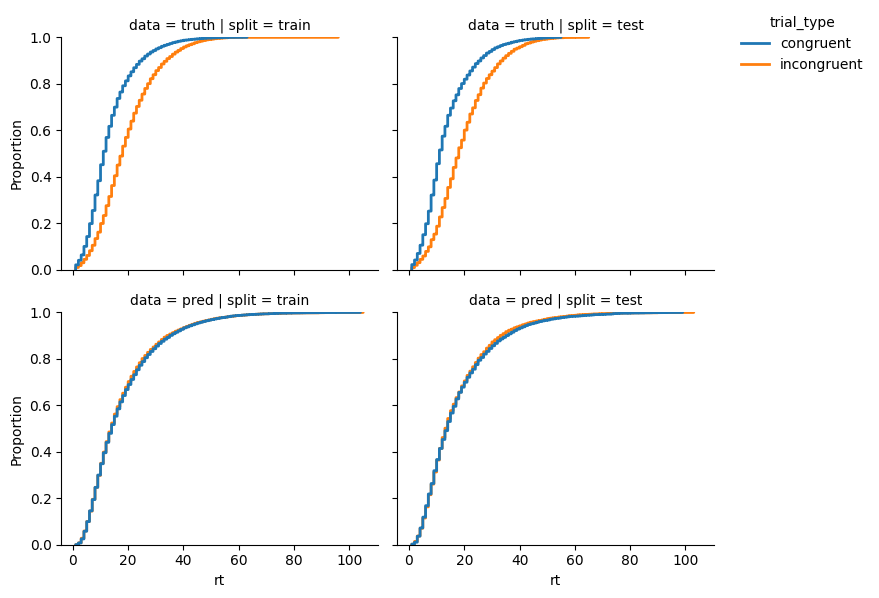

In [17]:

g = sns.displot(
    plot_data,
    x='rt', row='data', col='split', hue='trial_type',
    kind='ecdf', linewidth=2, height=3,
)

sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))


# plt.title(f'Evaluation profile of CogPonder on train split (Stroop)')

plt.tight_layout()
plt.show()


And plot the overall predicted response time distribution.

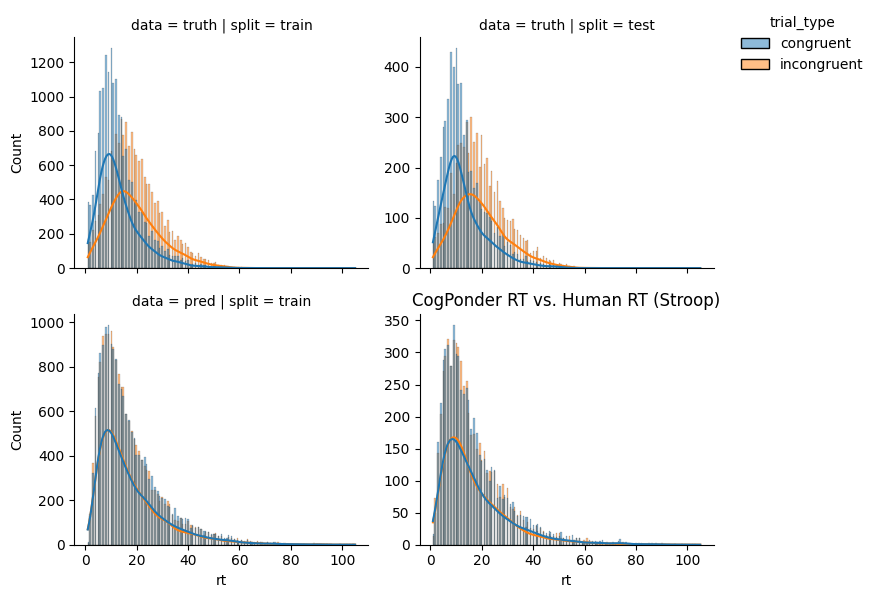

In [23]:
g = sns.displot(
    plot_data.reset_index(),
    x='rt', row='data', col='split', hue='trial_type',
    kind='hist', height=3,
    kde=True, kde_kws={'clip': (0, max_rt)},
    facet_kws={'sharey': False}
)

sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
plt.title(f'CogPonder RT vs. Human RT (Stroop)')

plt.tight_layout()
plt.show()
